<a href="https://colab.research.google.com/github/aldamian/H3-Hackathon/blob/main/OCR_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup

In [1]:
!sudo apt install tesseract-ocr
!sudo apt install tesseract-ocr-ron - tesseract-ocr 
!sudo apt install poppler-utils
!pip install pytesseract
!pip install pdf2image

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
tesseract-ocr-ron is already the newest version (4.00~git24-0e00fe6-1.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.12).
The following package 

In [3]:
import shutil
import os
import random
import pytesseract
from PIL import Image, ImageDraw
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pdf2image import convert_from_path
from google.colab.patches import cv2_imshow
from google.colab import drive

In [23]:
# drive._mount("/content/gdrive")
%cd /content/drive/MyDrive/Colab Notebooks/Data

/content/drive/MyDrive/Colab Notebooks/Data


# Document

Externare.pdf

In [52]:
images = convert_from_path("Externare.pdf")
fp = images[0]
sp = images[1]

In [50]:
print(images)
print(fp.size)

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200 at 0x7FDAA20289D0>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200 at 0x7FDAA2028550>]
(1700, 2200)


In [56]:
def pil_to_cv(pil_image):
  cv_image = np.array(pil_image)
  # Convert RGB to BGR 
  return cv_image[:, :, ::-1].copy()

In [61]:
fp = pil_to_cv(fp)
sp = pil_to_cv(sp)

In [63]:
# cv2_imshow(fp)

In [64]:
cv2.imwrite("/tmp/fp.png", fp)

True

In [65]:
cv2.imwrite("/tmp/sp.png", sp)

True

In [71]:
# Need correct data format
fp = cv2.imread("/tmp/fp.png")
sp = cv2.imread("/tmp/sp.png")

In [80]:
#https://stackoverflow.com/questions/28816046/
#displaying-different-images-with-actual-size-in-matplotlib-subplot
def display(im_path):
  dpi = 80
  im_data = plt.imread(im_path)
  height, width, depth = im_data.shape

  # What size does the figure need to be in inches to fit the image?
  figsize = width / float(dpi), height / float(dpi)

  # Create a figure of the right size with the axes that takes up the full figure
  fig = plt.figure(figsize=figsize)
  ax = fig.add_axes([0, 0, 1, 1])

  # Hide spines, ticks, etc. 
  ax.axis('off')

  # Display the image
  ax.imshow(im_data, cmap='gray')

  plt.show()

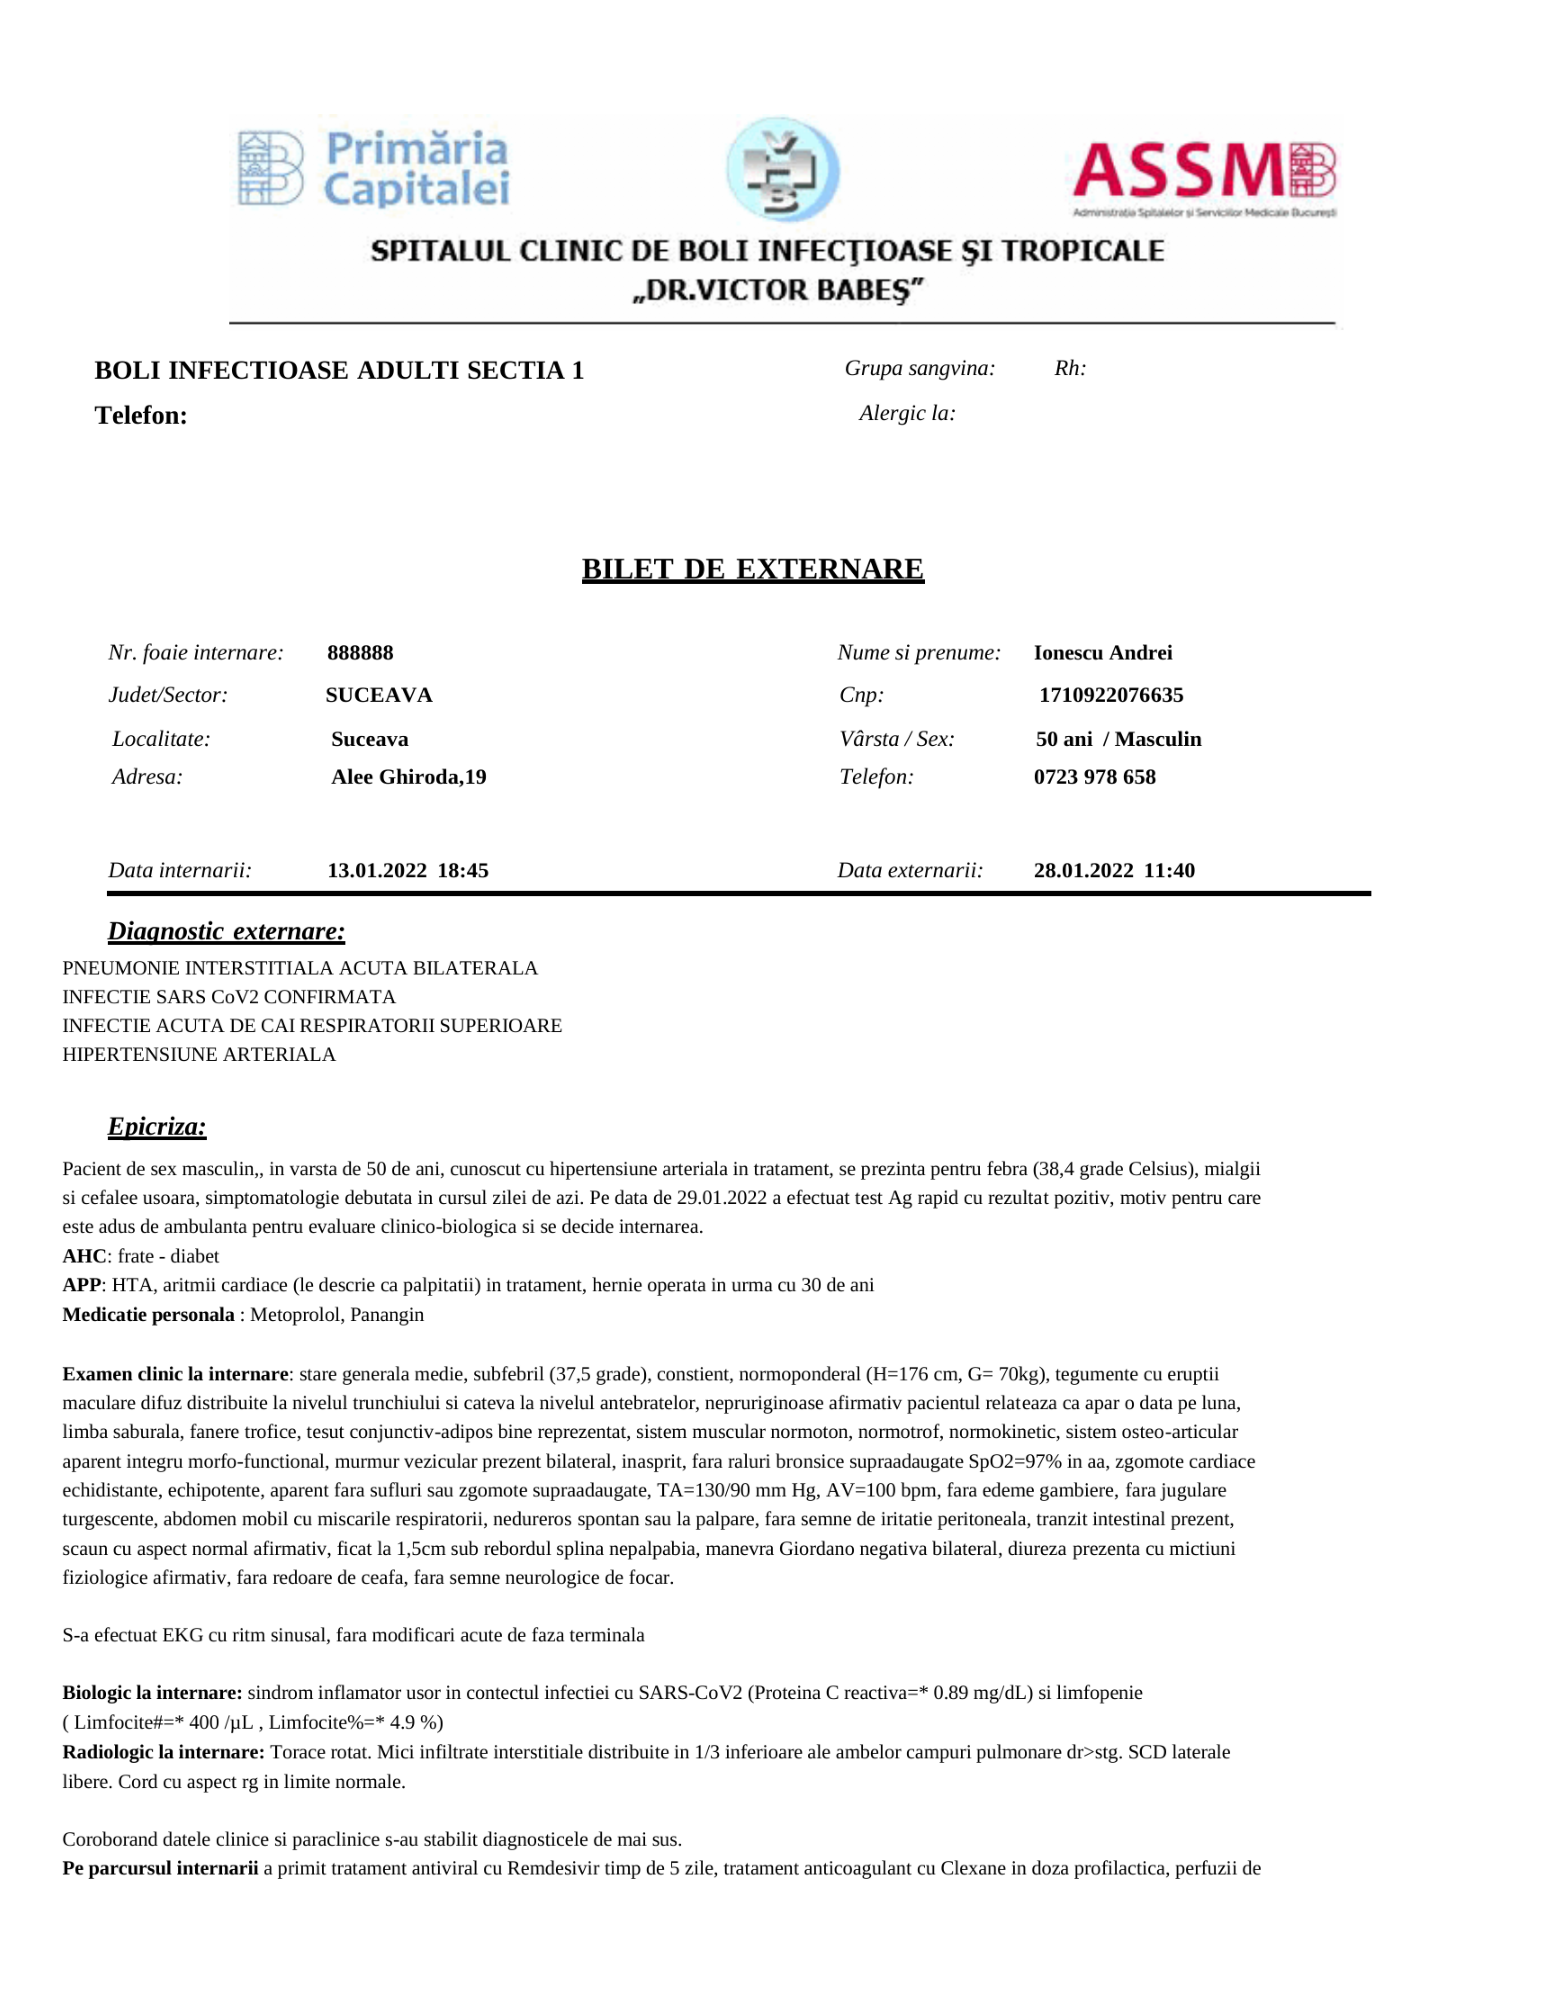

In [87]:
display("/tmp/fp.png")

# Pre-processing - Rotation / Deskewing

Much of the methods were unnecessary.  
The only useful one for this particular scenario is Rotation in case the user's picture is not straight. 

In [230]:
#https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df
import numpy as np

def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

In [232]:
# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

# OCR with PyTesseract

In [97]:
fp_text = pytesseract.image_to_string(fp)
# print(fp_text)

In [96]:
sp_text = pytesseract.image_to_string(sp)


In [199]:
text = fp_text + sp_text
text = text.replace('$', 'S')
# print(text)

# Rules Based NER

In [200]:
text = text.split("\n\n")
text.remove(' ')
text.pop()
text.pop(0)

'ps |\nCapitalel = ASSM®'

In [296]:
new_text = []
for segment in text:
  segment = segment.strip()
  segment = segment.lower()
  # keep percentages, points, slash, star
  punc = '''!()[]{};'",<>?@#$^&_~"”»'''
  for ele in segment:
      if ele in punc:
          segment = segment.replace(ele, "")

  new_text.append(segment)
  print(segment)

spitalul clinic de boli infectioase si tropicale
dr.victor babes

boli infectioase adulti sectia 1 grupa sangvina: rh:
telefon: alergic la:
bilet de externare
nr. foaie internare: 888888 nume si prenume: ionescu andrei
judet/sector: suceava cnp: 1710922076635
localitate: suceava varsta / sex: 50 ani / masculin
adresa: alee ghiroda19 telefon: 0723 978 658
data internarii: 13.01.2022 18:45 data externarii: 28.01.2022 11:40

diagnostic externare:
pneumonie interstitiala acuta bilaterala
infectie sars cov2 confirmata
infectie acuta de cai respiratorii superioare
hipertensiune arteriala
epicriza:
pacient de sex masculin in varsta de 50 de ani cunoscut cu hipertensiune arteriala in tratament se prezinta pentru febra 384 grade celsius mialgii
si cefalee usoara simptomatologie debutata in cursul zilei de azi. pe data de 29.01.2022 a efectuat test ag rapid cu rezultat pozitiv motiv pentru care
este adus de ambulanta pentru evaluare clinico-biologica si se decide internarea.
ahc: frate - diabet


In [295]:
def date_split(text):
  if text.count("data") == 1:
    return text.split("data")[0]
  return "data".join(text.split("data", 2)[:2])

In [275]:
hospital = new_text[0]
department = new_text[2].split('grupa')[0]

dates = new_text[4].splitlines()[-1]
admission_date = date_split(dates)
discharge_date = dates.replace(admission_date, '')

discharge_diagnostic = new_text[6].split(':')[1]
epicrisis = new_text[7].split(':', 1)[1].capitalize()
inpatient_clinical_exam = new_text[8].split(':', 1)[1].lstrip() + '\n\n' + new_text[9].capitalize()
inpatient_biological_exam = new_text[10].strip() + '\n' + new_text[11].lstrip()
inpatient_radiology = new_text[12].split(':', 1)[1].lstrip().capitalize()
treatment = new_text[13].split('.', 1)[1].capitalize()

In [ ]:
"""
class DischargeTicket:
  def __init__(self, _hospital, _department, _admission_date, _discharge, )
"""


# Long term - goal: general approach

Discharge receipts very to a considerable degree, so a rules based approach is naive at best.

Solutions:

1. Use ML for NER  - spaCy's NER 
2. Generate custom word vectors in Gensim because spaCy's models are trained on news and media, and as a result they perform poor in specialized domains such as law or healthcare
3. Traing spaCy's NER on domain specific texts: (eg. 50,000 discharge receipts)
4. Look into syntetic data

Note: Used spaCy's large romanian language model in another notebook but the results were very poor. 

# Experiment - Translate text to EN to perform NLP and back to RO for display

Tried to use deepL translation API but it doesn't yet support romanian.   
Google translate is accurate but there's a 5000 word limit.  



In [49]:
# !pip install deep_translator

In [26]:
"""
from deep_translator import GoogleTranslator

fp_en = GoogleTranslator(source='ro', target='en').translate(fp_text)
fp_ro = GoogleTranslator(source='en', target='ro').translate(fp_en)
"""